<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

--2022-11-13 22:46:22--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2022-11-13 22:46:22--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2022-11-13 22:46:22--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

### Se elije la artista "Amy Winehouse"

In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['lin-manuel-miranda.txt',
 'jimi-hendrix.txt',
 'leonard-cohen.txt',
 'rihanna.txt',
 'dolly-parton.txt',
 'nickelback.txt',
 'dj-khaled.txt',
 'adele.txt',
 'drake.txt',
 'missy-elliott.txt',
 'nirvana.txt',
 'notorious_big.txt',
 'bjork.txt',
 'michael-jackson.txt',
 'lil-wayne.txt',
 'britney-spears.txt',
 'blink-182.txt',
 'dickinson.txt',
 'r-kelly.txt',
 'lorde.txt',
 'johnny-cash.txt',
 'cake.txt',
 'bob-dylan.txt',
 'janisjoplin.txt',
 'bruce-springsteen.txt',
 'al-green.txt',
 'bieber.txt',
 'bruno-mars.txt',
 'prince.txt',
 'bob-marley.txt',
 'beatles.txt',
 'joni-mitchell.txt',
 'ludacris.txt',
 'alicia-keys.txt',
 'patti-smith.txt',
 'kanye-west.txt',
 'lady-gaga.txt',
 'amy-winehouse.txt',
 'disney.txt',
 'eminem.txt',
 'paul-simon.txt',
 'Kanye_West.txt',
 'dr-seuss.txt',
 'nicki-minaj.txt',
 'radiohead.txt',
 'kanye.txt',
 'notorious-big.txt',
 'Lil_Wayne.txt',
 'nursery_rhymes.txt']

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/amy-winehouse.txt', sep='/n', header=None)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,Build your dreams to the stars above
1,But when you need someone to love
2,"Don't go to strangers, darling, come to me Pla..."
3,And when there's no place for you to turn
4,"Don't go to strangers, darling, come to me For..."


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1910


### 1 - Preprocesamiento

In [6]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [7]:
# Demos un vistazo
sentence_tokens[:2]

[['build', 'your', 'dreams', 'to', 'the', 'stars', 'above'],
 ['but', 'when', 'you', 'need', 'someone', 'to', 'love']]

### 2 - Crear los vectores (word2vec)

In [8]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [9]:
# Crearmos el modelo generador de vectoeres
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [10]:
# Buildear el vocabularui con los tokens
w2v_model.build_vocab(sentence_tokens)

In [11]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 1910


In [12]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.vocab))

Cantidad de words distintas en el corpus: 474


### 3 - Entrenar el modelo generador

In [13]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 142103.4375
Loss after epoch 1: 74855.40625
Loss after epoch 2: 72627.625
Loss after epoch 3: 72881.4375
Loss after epoch 4: 72434.25
Loss after epoch 5: 72379.40625
Loss after epoch 6: 73814.75
Loss after epoch 7: 74481.75
Loss after epoch 8: 72967.25
Loss after epoch 9: 71710.0
Loss after epoch 10: 72605.3125
Loss after epoch 11: 71264.125
Loss after epoch 12: 69989.8125
Loss after epoch 13: 65413.0625
Loss after epoch 14: 61148.0
Loss after epoch 15: 61325.375
Loss after epoch 16: 61077.625
Loss after epoch 17: 60671.125
Loss after epoch 18: 60499.875
Loss after epoch 19: 60498.5


(170151, 312520)

### 4 - Ensayar

In [14]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["darling"], topn=10)

[('strangers', 0.9888522624969482),
 ('let', 0.9714409112930298),
 ('cupid', 0.9650777578353882),
 ('together', 0.9595413208007812),
 ('watch', 0.9588560461997986),
 ('please', 0.9378678798675537),
 ('dreams', 0.9360078573226929),
 ('tonight', 0.9356361627578735),
 ('pay', 0.9335839748382568),
 ('back', 0.9333885908126831)]

In [22]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["soul"], topn=10)

[('been', -0.6030138731002808),
 ('good', -0.6031433343887329),
 ('amy', -0.605891764163971),
 ('ooh', -0.6378011703491211),
 ('oh', -0.641907811164856),
 ('help', -0.6421548128128052),
 ('come', -0.643938422203064),
 ('over', -0.6512278914451599),
 ('valerie', -0.6518512964248657),
 ('day', -0.6524618268013)]

In [17]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["love"], topn=10)

[('tomorrow', 0.9654028415679932),
 ('still', 0.9433743357658386),
 ('is', 0.9186098575592041),
 ('tonight', 0.8944367170333862),
 ('let', 0.8788268566131592),
 ('will', 0.8470509052276611),
 ('pay', 0.830564022064209),
 ('losing', 0.8288018703460693),
 ('mister', 0.827900767326355),
 ("you'd", 0.8234384655952454)]

In [29]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["dreams"], topn=5)

[('every', 0.9856407046318054),
 ('lips', 0.9812637567520142),
 ('pay', 0.9773721694946289),
 ('together', 0.9728298783302307),
 ('safe', 0.9681685566902161)]

### Interesante que con su comportamiento y letras no figure "sad"

In [33]:
# Ensayar con una palabra que no está en el corpus (en vocab):
w2v_model.wv.most_similar(negative=["sad"])

KeyError: ignored

In [40]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["night"], topn=15)

[('sky', 0.9813195466995239),
 ('above', 0.9800458550453186),
 ('blue', 0.9718438982963562),
 ('smoke', 0.9700748920440674),
 ('head', 0.9688273668289185),
 ('beat', 0.9653822779655457),
 ('point', 0.964715838432312),
 ('wake', 0.962746798992157),
 ('live', 0.9616473317146301),
 ('aye', 0.9599539041519165),
 ('forget', 0.9593154191970825),
 ('them', 0.9579521417617798),
 ('shirt', 0.9560445547103882),
 ('way', 0.9531716704368591),
 ('two', 0.9527816772460938)]

### Se puede considerar que "smoke, men death, final " etc son parte de la "vida" en las canciones de Winehouse.

In [45]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["live"], topn=15)

[('aye', 0.9925061464309692),
 ('forget', 0.992495059967041),
 ('them', 0.9913175106048584),
 ('green', 0.9910521507263184),
 ('point', 0.9908748865127563),
 ('death', 0.9902666211128235),
 ('fighting', 0.9899044632911682),
 ('consider', 0.9882664680480957),
 ('stars', 0.9876664280891418),
 ('without', 0.9873721599578857),
 ('final', 0.9868655204772949),
 ('men', 0.9868565797805786),
 ('smoke', 0.9867504239082336),
 ('supposed', 0.9857783913612366),
 ('last', 0.9855659008026123)]

### 5 - Visualizar agrupación de vectores

In [34]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [41]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### Alumno

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

[link text](https:// [link text](https://))

## Conclusiones

#### Se eligió las canciones de "Amy Winehouse" - cantante de blues, soul y jazz- Se analizaron palabras relacionadas a sus canciones, por ejemplo love, stay , etc. Aunque son palabras que abundan en las canciones tambien es interesante como el algoritmo relaciona algunas con "night" y ninguna con "sad". Siendo que las canciones de amy tienen a ese sentimiento. 
#### Entre palabras muy relacionadas tenemos he-walks-away, tears-dry, still-love-tomorrow, best-friends-right, siendo estas relaciones "nostalgicas" por otro lado tenemos huggin-monkey-big y muy cerca "man", y tambien "night, blue, man, smoke, life, soul" que seria el ambiente de sus canciones.. 


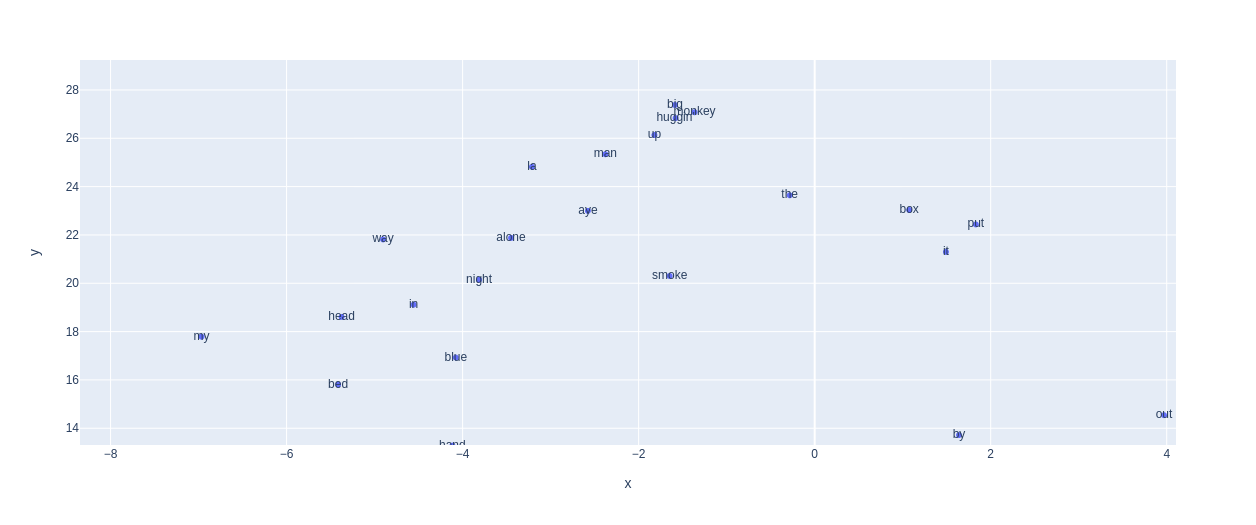

### Por lo tanto 'Gensim' como generador de embeddings es muy útil para determinar en el caso de canciones el tipo y genero si se utiliza otro algoritmo detectar estas relaciones... Además veo la posibilidad de un artista que puede tomar en Amy Winehouse inspiración para sus propias canciones al ver las relaciones y/o comparar artistas y determinar si pertenecen a un genero de música similar. 